In [ ]:
import math
from typing import List

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import os
import warnings
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# Helper layers & utilities
# ---------------------------------------------------------

class PixelNorm(nn.Module):
    def __init__(self, eps: float = 1e-8):
        super().__init__()
        self.eps = eps
    def forward(self, x):
        return x * torch.rsqrt(x.pow(2).mean(1, keepdim=True) + self.eps)

class WeightScale(nn.Module):
    """Equalized learning-rate wrapper for Conv2d/Linear modules."""
    def __init__(self, mod: nn.Module):
        super().__init__()
        # initialize weights and bias
        nn.init.normal_(mod.weight)
        if mod.bias is not None:
            nn.init.zeros_(mod.bias)
        # store wrapped module under 'module' to match checkpoint
        self.mod = mod
        fan_in = mod.weight.data.size(1) * mod.weight.data[0][0].numel()
        self.scale = math.sqrt(2.0 / fan_in)
    def forward(self, x):
        # scale input
        return self.mod(x * self.scale)

def conv2d(in_ch, out_ch, kernel=3, padding=1):
    return WeightScale(nn.Conv2d(in_ch, out_ch, kernel, padding=padding))

def linear(in_f, out_f):
    return WeightScale(nn.Linear(in_f, out_f))

class MinibatchStdDev(nn.Module):
    def __init__(self, group_size: int = 4, eps: float = 1e-8):
        super().__init__()
        self.group_size = group_size
        self.eps = eps
    def forward(self, x):
        B, C, H, W = x.shape
        G = min(self.group_size, B)
        if B % G:
            G = B
        y = x.view(G, -1, C, H, W)
        y = y - y.mean(dim=0, keepdim=True)
        y = torch.sqrt(y.pow(2).mean(dim=0) + self.eps)
        y = y.mean(dim=[1,2,3], keepdim=True).repeat(G,1,H,W)
        return torch.cat([x, y], dim=1)

# ---------------------------------------------------------
# Progressive blocks
# ---------------------------------------------------------

class GenBlock(nn.Module):
    def __init__(self, in_c: int, out_c: int):
        super().__init__()
        self.conv1 = conv2d(in_c, out_c)
        self.conv2 = conv2d(out_c, out_c)
        self.act = nn.LeakyReLU(0.2)
        self.pn = PixelNorm()
    def forward(self, x):
        x = self.pn(self.act(self.conv1(F.interpolate(x, scale_factor=2))))
        x = self.pn(self.act(self.conv2(x)))
        return x

class DiscBlock(nn.Module):
    def __init__(self, in_c: int, out_c: int):
        super().__init__()
        self.conv1 = conv2d(in_c, in_c)
        self.conv2 = conv2d(in_c, out_c)
        self.act = nn.LeakyReLU(0.2)
    def forward(self, x):
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        return F.avg_pool2d(x, 2)

# ---------------------------------------------------------
# Generator
# ---------------------------------------------------------

class cProGenerator(nn.Module):
    def __init__(self, latent_dim: int = 128, n_classes: int = 80,
                 max_resolution: int = 28, fmap_base: int = 512, base: int = 7):
        super().__init__()
        k = max_resolution // base
        assert max_resolution % base == 0 and (k & (k - 1) == 0) and max_resolution >= base
        self.max_step = int(math.log2(k))
        self.embed = nn.Embedding(n_classes, latent_dim)
        self.fc = linear(latent_dim*2, fmap_base*7*7)
        self.blocks = nn.ModuleList()
        self.to_rgb = nn.ModuleList([WeightScale(nn.Conv2d(fmap_base, 3, 1))])
        c = fmap_base
        for s in range(1, self.max_step+1):
            oc = max(fmap_base//(2**s), 16)
            self.blocks.append(GenBlock(c, oc))
            self.to_rgb.append(WeightScale(nn.Conv2d(oc, 3, 1)))
            c = oc
        self.act = nn.LeakyReLU(0.2)
        self.pn = PixelNorm()

    def forward(self, z, y, step, alpha):
        """
        z:     (B, latent_dim)
        y:     (B,) long tensor of class indices
        step:  which resolution (0=4×4, 1=8×8, 2=16×16, 3=32×32)
        alpha: fade-in factor ∈ [0,1]
        """
        B = z.size(0)

        # 1) embed & combine
        e = self.embed(y)                         # (B, latent_dim)
        x = torch.cat([z, e], dim=1)              # (B, latent_dim*2)
        x = self.pn(x)                            # PixelNorm
        x = self.fc(x).view(B, -1, 7, 7)          # → (B, fmap_base, 4, 4)
        x = self.pn(self.act(x))                  # non-lin + PixelNorm

        # 2) no growing: direct 4×4 → RGB
        if step == 0:
            return torch.tanh(self.to_rgb[0](x))

        # 3) grow up to previous resolution
        #    apply blocks[0] … blocks[step-2] to reach (4×4 → … → 4×4·2^(step-1))
        for s in range(step-1):
            x = self.blocks[s](x)

        # 4) capture previous-resolution image for fade
        img_prev = self.to_rgb[step-1](x)         # (B,3, 4·2^(step-1), 4·2^(step-1))

        # 5) apply last block → current resolution
        x = self.blocks[step-1](x)                # upsamples to (B, C_step, R, R)
        img_hi = self.to_rgb[step](x)             # (B,3, R, R)

        # 6) fade-in
        if 0 < alpha < 1.0:
            img_lo = F.interpolate(img_prev,
                                    scale_factor=2,
                                    mode="nearest")
            img = alpha * img_hi + (1 - alpha) * img_lo
        else:
            img = img_hi

        return torch.tanh(img)

# ---------------------------------------------------------
# Discriminator
# ---------------------------------------------------------

class cProDiscriminator(nn.Module):
    def __init__(self, n_classes: int = 80, max_resolution: int = 28,
                 fmap_base: int = 512, base: int = 7):
        super().__init__()
        k = max_resolution // base
        assert max_resolution % base == 0 and (k & (k - 1) == 0) and max_resolution >= base
        self.max_step = int(math.log2(k))
        self.from_rgb = nn.ModuleList([WeightScale(nn.Conv2d(3, fmap_base, 1))])
        self.blocks = nn.ModuleList()
        c = fmap_base
        for s in range(1, self.max_step+1):
            oc = max(fmap_base//(2**(s-1)), 16)
            self.from_rgb.append(WeightScale(nn.Conv2d(3, oc, 1)))
            self.blocks.append(DiscBlock(oc, c))
            c = oc
        self.std = MinibatchStdDev()
                # FIX: load from checkpoint shaped for fmap_base+1 (513) channels
        self.final_conv = WeightScale(nn.Conv2d(fmap_base + 1, fmap_base, 3, padding=1))
        self.adv_dense = linear(fmap_base * 7 * 7, 1)
        self.cls_dense = linear(fmap_base * 7 * 7, n_classes)
        self.act = nn.LeakyReLU(0.2)
    def forward(self, img, step, alpha):
        res = 7 * (2**step)
        x = F.adaptive_avg_pool2d(img, res)
        x = self.act(self.from_rgb[step](x))
        if step > 0:
            hi = self.blocks[step-1](x)
            prev = res//2
            skip = F.adaptive_avg_pool2d(img, prev)
            skip = self.act(self.from_rgb[step-1](skip))
            x = alpha*hi + (1-alpha)*skip
            for s in reversed(range(step-1)):
                x = self.blocks[s](x)
        x = self.std(x)
        x = self.act(self.final_conv(x)).view(x.size(0), -1)
        return self.adv_dense(x), self.cls_dense(x)

# ---------------------------------------------------------
# Scheduling helper
# ---------------------------------------------------------
def grow_schedule(max_res, ep, base_res=7):
    k = max_res // base_res
    assert max_res % base_res == 0 and (k & (k-1) == 0)
    max_step = int(math.log2(k))
    fade = max(1, ep // 2)  # guard against very small ep
    def _sched(epoch):
        step = min(epoch // ep, max_step)

        if step == max_step:
          return step, 1.0

        local = epoch % ep
        alpha = local / fade if local < fade else 1.0
        return step, alpha
    return _sched


[Epoch 1/1000] D_loss: 3.3454, G_loss: 4.1622
[Epoch 2/1000] D_loss: 3.0436, G_loss: 1.8218
[Epoch 3/1000] D_loss: 2.8806, G_loss: 1.4588
[Epoch 4/1000] D_loss: 2.7523, G_loss: 1.4137
[Epoch 5/1000] D_loss: 2.6628, G_loss: 1.4042
[Epoch 6/1000] D_loss: 2.5988, G_loss: 1.3921
[Epoch 7/1000] D_loss: 2.5589, G_loss: 1.3490
[Epoch 8/1000] D_loss: 2.5569, G_loss: 1.2996
[Epoch 9/1000] D_loss: 2.5133, G_loss: 1.3019
[Epoch 10/1000] D_loss: 2.4682, G_loss: 1.2917
[Epoch 11/1000] D_loss: 2.4039, G_loss: 1.3564
[Epoch 12/1000] D_loss: 2.3310, G_loss: 1.4145
[Epoch 13/1000] D_loss: 2.2728, G_loss: 1.4467
[Epoch 14/1000] D_loss: 2.2436, G_loss: 1.4561
[Epoch 15/1000] D_loss: 2.2255, G_loss: 1.4485
[Epoch 16/1000] D_loss: 2.2051, G_loss: 1.4400
[Epoch 17/1000] D_loss: 2.2127, G_loss: 1.3768
[Epoch 18/1000] D_loss: 2.2063, G_loss: 1.3729
[Epoch 19/1000] D_loss: 2.1922, G_loss: 1.3939
[Epoch 20/1000] D_loss: 2.1619, G_loss: 1.4012
[Epoch 21/1000] D_loss: 2.1249, G_loss: 1.3844
[Epoch 22/1000] D_loss

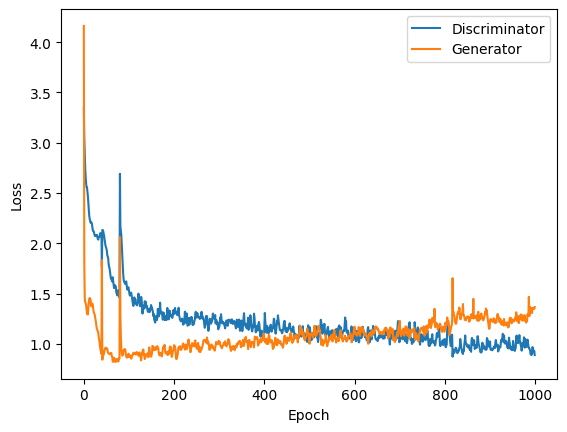

<Figure size 640x480 with 0 Axes>

In [ ]:
# from ACGAN import ACDiscriminator, ACGenerator

warnings.filterwarnings("ignore", "Truncated File Read", UserWarning)


class LatentImageDataset(Dataset):
    def __init__(self, latents_npy, filenames_npy, labels_npy, image_root, subject, transform):
        self.latents   = np.load(latents_npy)    # (N, 128)
        self.filenames = np.load(filenames_npy,allow_pickle=True)  # (N,), dtype=str
        self.labels_str= np.load(labels_npy)     # (N,), dtype=str
        self.image_root= image_root
        self.transform = transform
        self.sub = subject
        # build mapping from string label → integer in [0,80)
        classes = np.unique(self.labels_str)
        self.cls2idx = {c:i for i,c in enumerate(classes)}

    def __len__(self):
        return len(self.latents)

    def __getitem__(self, idx):
        # latent
        z = torch.from_numpy(self.latents[idx]).float()
        # image
        cls = self.labels_str[idx]
        img_path = os.path.join(self.image_root, cls, self.filenames[idx])
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)
        # integer label
        y = torch.tensor(self.cls2idx[cls], dtype=torch.long)
        return z, img, y


# transforms & dataloaders
img_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.CenterCrop(28),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])

g = "fine3"

train_ds = LatentImageDataset(
    latents_npy   = f"/content/drive/MyDrive/ImageNet_Images/latent_dumps/granularity/Time/all_channels/{g}/train_latents.npy",
    filenames_npy = f"/content/drive/MyDrive/ImageNet_Images/latent_dumps/granularity/Time/all_channels/{g}/train_filenames.npy",
    labels_npy    = f"/content/drive/MyDrive/ImageNet_Images/latent_dumps/granularity/Time/all_channels/{g}/train_stringLabels.npy",
    image_root    = f"/content/drive/MyDrive/ImageNet_Images/images_80class",
    subject  = f"/content/drive/MyDrive/ImageNet_Images/latent_dumps/granularity/Time/all_channels/{g}/train_subject.npy",
    transform     = img_transform,
)
train_dataloader = DataLoader(train_ds, batch_size=256, num_workers=4, shuffle=True, drop_last=True)

val_latents   = np.load(f"/content/drive/MyDrive/ImageNet_Images/latent_dumps/granularity/Time/all_channels/{g}/val_latents.npy")       # (N_val, 128)
val_labels    = np.load(f"/content/drive/MyDrive/ImageNet_Images/latent_dumps/granularity/Time/all_channels/{g}/val_stringLabels.npy")  # (N_val,), dtype=str
val_filenames = np.load(f"/content/drive/MyDrive/ImageNet_Images/latent_dumps/granularity/Time/all_channels/{g}/val_filenames.npy",allow_pickle=True)  # (N_val,)
val_subject   = np.load(f"/content/drive/MyDrive/ImageNet_Images/latent_dumps/granularity/Time/all_channels/{g}/train_subject.npy")

test_ds = LatentImageDataset(
    latents_npy   = f"/content/drive/MyDrive/ImageNet_Images/latent_dumps/granularity/Time/all_channels/{g}/test_latents.npy",
    filenames_npy = f"/content/drive/MyDrive/ImageNet_Images/latent_dumps/granularity/Time/all_channels/{g}/test_filenames.npy",
    labels_npy    = f"/content/drive/MyDrive/ImageNet_Images/latent_dumps/granularity/Time/all_channels/{g}/test_stringLabels.npy",
    image_root    = f"/content/drive/MyDrive/ImageNet_Images/images_80class",
    subject       = f"/content/drive/MyDrive/ImageNet_Images/latent_dumps/granularity/Time/all_channels/{g}/test_subject.npy",
    transform     = img_transform,
)
test_dataloader = DataLoader(test_ds, batch_size=256, shuffle=False,num_workers=4, drop_last=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

result_folder = f'/content/drive/MyDrive/ImageNet_Images/GANs - {g}/cProGAN/cProGAN-result'
if not os.path.exists(result_folder ):
    os.makedirs(result_folder )

save_path    = f"/content/drive/MyDrive/ImageNet_Images/GANs - {g}/cProGAN/cProGAN_checkpoint"
if not os.path.exists(save_path):
    os.makedirs(save_path)

with open(os.path.join(f'/content/drive/MyDrive/ImageNet_Images/GANs - {g}/capsGAN28/capsGAN-result', "fixed_val_filenames.txt")) as f:
    fixed_filenames = [ln.strip() for ln in f if ln.strip()]

fname_to_idx = {fn: i for i, fn in enumerate(val_filenames)}
fixed_idxs   = [fname_to_idx[fn] for fn in fixed_filenames]

fixed_latents = torch.from_numpy(val_latents[fixed_idxs]).float().to(device)
cls2idx = train_ds.cls2idx
fixed_label_strs = [val_labels[i] for i in fixed_idxs]
fixed_label_idxs = [cls2idx[s]           for s in fixed_label_strs]
fixed_labels     = torch.tensor(
    fixed_label_idxs, dtype=torch.long, device=device
)

# instantiate AC-GAN
n_classes = 8
generator     = cProGenerator(latent_dim=128, n_classes=n_classes).to(device)
discriminator = cProDiscriminator(n_classes=n_classes).to(device)

# losses
adversarial_loss = nn.BCEWithLogitsLoss()
auxiliary_loss   = nn.CrossEntropyLoss()

# optimisers and learning rate
lr = 2e-4
optimiserG = optim.Adam(generator.parameters(),    lr=lr,    betas=(0.5, 0.999))
optimiserD = optim.Adam(discriminator.parameters(),lr=lr/2,    betas=(0.5, 0.999))

# Total loss history for both networks
D_loss_history = []
G_loss_history = []

# ckpt = torch.load(f"/content/drive/MyDrive/ImageNet_Images/GANs - {g}/cProGAN/cProGAN_checkpoint/cProGANcheckpoint_e650.pth")
# generator.load_state_dict(ckpt["generator_state"])
# discriminator.load_state_dict(ckpt["discriminator_state"])
# epoch_start     = ckpt['epoch'] + 1
# optimiserG.load_state_dict(ckpt['optimiserG_state'])
# optimiserD.load_state_dict(ckpt['optimiserD_state'])
# D_loss_history, G_loss_history = ckpt['D_loss_history'],ckpt['G_loss_history']


# helper for real/fake ground-truth
def make_labels(size, is_real, device):
    # is_real=True → all ones, False → all zeros
    low,high = (0.8,1.0) if is_real else (0.0,0.2)
    return torch.empty(B,1,device=device).uniform_(low,high)



LAMBDA_C = 2.0
sigma0 = 0.05

grow = grow_schedule(max_res=28, ep=40)

# training loop
num_epochs = 1000
for epoch in range(1, num_epochs+1):
    D_loss_epoch = 0.0
    G_loss_epoch = 0.0

    step, alpha = grow(epoch-1)          # epoch is 1-based in loop

    #Put both networks into training mode
    generator.train()
    discriminator.train()

    for z, real_imgs, labels in train_dataloader:
        B = real_imgs.size(0)
        z          = z.to(device)
        real_imgs  = real_imgs.to(device)
        labels     = labels.to(device)

        # ── Train Discriminator ──

        validity_real, pred_cls_real = discriminator(real_imgs,step,alpha)
        real_gt  = make_labels(B, True,  device)
        lossD_real_adv = adversarial_loss(validity_real, real_gt)
        lossD_real_cls = auxiliary_loss(pred_cls_real, labels)

        # fake
        fake_imgs = generator(z, labels,step,alpha).detach()
        validity_fake, pred_cls_fake = discriminator(fake_imgs,step,alpha)
        fake_gt  = make_labels(B, False, device)
        lossD_fake_adv = adversarial_loss(validity_fake, fake_gt)

        #Total loss and optimister step
        lossD = lossD_real_adv + lossD_fake_adv + lossD_real_cls

        optimiserD.zero_grad()
        lossD.backward()
        optimiserD.step()

        # ── Train Generator ──

        gen_imgs = generator(z, labels,step,alpha)
        validity, pred_cls = discriminator(gen_imgs,step,alpha)
        # want discriminator to label these as “real”
        lossG_adv = adversarial_loss(validity, real_gt)
        # want discriminator to predict the correct class
        lossG_cls = auxiliary_loss(pred_cls, labels)

        lossG = lossG_adv + LAMBDA_C*lossG_cls

        optimiserG.zero_grad()
        lossG.backward()
        optimiserG.step()

        D_loss_epoch += lossD.item()
        G_loss_epoch += lossG.item()

    print(f"[Epoch {epoch}/{num_epochs}] "
          f"D_loss: {D_loss_epoch/len(train_dataloader):.4f}, "
          f"G_loss: {G_loss_epoch/len(train_dataloader):.4f}")

    avg_D = D_loss_epoch / len(train_dataloader)
    avg_G = G_loss_epoch / len(train_dataloader)
    D_loss_history.append(avg_D)
    G_loss_history.append(avg_G)


    if epoch % 5 == 0:
        with torch.no_grad():
            generator.eval()
            fake = generator(fixed_latents, fixed_labels,step,alpha)    # now pass labels too
            grid = torchvision.utils.make_grid(
                fake,
                nrow=10,
                normalize=True,
                value_range=(-1,1)
            )
            np_grid = grid.cpu().permute(1,2,0).numpy()
            fig, ax = plt.subplots(figsize=(6,6))
            ax.imshow(np_grid)
            ax.axis("off")
            ax.set_title(
                f"Epoch {epoch}/{num_epochs}\n"
                f"D_loss: {avg_D:.4f}, G_loss: {avg_G:.4f}",
                fontsize=12,
                color="white",
                backgroundcolor="black",
                pad=10
            )
            plt.tight_layout()
            plt.savefig(os.path.join(result_folder, f"epoch{epoch:03d}_valgrid.png"))
            plt.close(fig)
            generator.train()

    # checkpointing:
    if epoch % 25 == 0 or avg_G < min(G_loss_history):
        torch.save({
            "epoch": epoch,
            "generator_state": generator.state_dict(),
            "discriminator_state": discriminator.state_dict(),
            "optimiserG_state": optimiserG.state_dict(),
            "optimiserD_state": optimiserD.state_dict(),
            "D_loss_history": D_loss_history,
            "G_loss_history": G_loss_history,
        }, os.path.join(save_path, f"cProGANcheckpoint_e{epoch:03d}.pth"))
        print(f"✓ checkpoint saved at epoch {epoch}")

plt.clf()
plt.plot(D_loss_history, label="Discriminator")
plt.plot(G_loss_history, label="Generator")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig(os.path.join(result_folder, "Network_Loss_History.png"))


In [ ]:
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings

def im_convert(tensor):
    '''
        Convert Tensor to displable format
    '''
    image = tensor.to("cpu").clone().detach()
    image = image.numpy()
    image = image.transpose(1,2,0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)

    return image


# 28×28 RGB, normalized to [-1,1]
img_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.CenterCrop(28),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])


class LatentImageDataset(Dataset):
    def __init__(self, latents_npy, filenames_npy, labels_npy,
                 image_root, subject, transform):
        self.latents    = np.load(latents_npy)        # (N,128)
        self.filenames  = np.load(filenames_npy, allow_pickle=True)      # (N,), dtype=str
        self.labels_str = np.load(labels_npy)         # (N,), dtype=str
        self.image_root = image_root
        self.transform  = transform
        self.sub = np.load(subject,allow_pickle=True)
        # build a str→int mapping once:
        classes = np.unique(self.labels_str)
        self.cls2idx = {c:i for i,c in enumerate(classes)}

        # also precompute the integer labels array:
        self.labels_int = np.array([self.cls2idx[c]
                                    for c in self.labels_str],
                                   dtype=np.int64)

    def __len__(self):
        return len(self.latents)

    def __getitem__(self, idx):
        # latent vector
        z     = torch.from_numpy(self.latents[idx]).float()

        # load + transform image
        cls   = self.labels_str[idx]
        fname = self.filenames[idx]
        path  = os.path.join(self.image_root, cls, fname)
        img   = Image.open(path).convert("RGB")
        img   = self.transform(img)
        subj = self.sub[idx]
        # get the integer label
        y_int = int(self.labels_int[idx])

        return z, img, fname, cls, y_int, subj

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

for g in ["fine1","fine2","fine3","coarse",]:

    test_ds = LatentImageDataset(
        latents_npy   = f"/content/drive/MyDrive/ImageNet_Images/latent_dumps/granularity/Time/all_channels/{g}/test_latents.npy",
        filenames_npy = f"/content/drive/MyDrive/ImageNet_Images/latent_dumps/granularity/Time/all_channels/{g}/test_filenames.npy",
        labels_npy    = f"/content/drive/MyDrive/ImageNet_Images/latent_dumps/granularity/Time/all_channels/{g}/test_stringLabels.npy",
        image_root    = f"/content/drive/MyDrive/ImageNet_Images/images_80class",
        subject       = f"/content/drive/MyDrive/ImageNet_Images/latent_dumps/granularity/Time/all_channels/{g}/test_subject.npy",
        transform     = img_transform,
    )
    test_loader = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=4)

    if g == "coarse" or g =="fine2":
        n_classes = 40
    else:
        n_classes = 8

    generator = cProGenerator(latent_dim=128,n_classes=n_classes).to(device)

    # 2) Load only the generator’s weights from checkpoint:
    ckpt = torch.load(f"/content/drive/MyDrive/ImageNet_Images/GANs - {g}/cProGAN/cProGAN_checkpoint/cProGANcheckpoint_e1000.pth", map_location=device)
    generator.load_state_dict(ckpt["generator_state"])

    # Create folder to hold result
    result_folder = f'/content/drive/MyDrive/ImageNet_Images/testResults/Time/{g}'
    if not os.path.exists(result_folder ):
        os.makedirs(result_folder )



    # After loading checkpoint & before/after training, do test‐time pass
    generator.eval()
    recon_folder = os.path.join(result_folder, f"cProGAN_reconstructions")
    os.makedirs(recon_folder, exist_ok=True)
    step, alpha = 2, 1.0

    with torch.no_grad():
        for latents, _, fnames, wnids, y_int,sub in test_loader:
            latents = latents.to(device)
            y = y_int.to(device)
            fakes   = generator(latents,y,step,alpha).cpu()          # (B,3,32,32)

            for i in range(fakes.size(0)):
                # convert tensor → numpy image
                img_np   = im_convert(fakes[i])

                base_name, _ = os.path.splitext(fnames[i])  # → ("n02510455_4381", ".JPEG")
                wnid         = wnids[i]                     # e.g. "n02510455"
                subject   = sub[i]

                out_dir = os.path.join(recon_folder, wnid)
                os.makedirs(out_dir, exist_ok=True)

                save_path = os.path.join(out_dir, f"{base_name}_{subject}.png")
                # PIL expects uint8 in [0,255]
                pil_img = Image.fromarray((img_np*255).astype(np.uint8))
                pil_img = pil_img.resize((64,64), Image.BICUBIC)
                pil_img.save(save_path)

    print(f"Saved all reconstructions to {recon_folder!r}")


cuda
Saved all reconstructions to '/content/drive/MyDrive/ImageNet_Images/testResults/Time/fine1/cProGAN_reconstructions'
Saved all reconstructions to '/content/drive/MyDrive/ImageNet_Images/testResults/Time/fine2/cProGAN_reconstructions'
Saved all reconstructions to '/content/drive/MyDrive/ImageNet_Images/testResults/Time/fine3/cProGAN_reconstructions'
Saved all reconstructions to '/content/drive/MyDrive/ImageNet_Images/testResults/Time/coarse/cProGAN_reconstructions'


In [ ]:
!pip install git+https://github.com/richzhang/PerceptualSimilarity
!pip install pytorch-fid


  Cloning https://github.com/richzhang/PerceptualSimilarity to /tmp/pip-req-build-mmmuc642
  Running command git clone --filter=blob:none --quiet https://github.com/richzhang/PerceptualSimilarity /tmp/pip-req-build-mmmuc642
  Resolved https://github.com/richzhang/PerceptualSimilarity to commit 082bb24f84c091ea94de2867d34c4544f68e0963
  Preparing metadata (setup.py) ... done
  Created wheel for lpips: filename=lpips-0.1.4-py3-none-any.whl size=53704 sha256=456af3543d953925c82985514e6afe2c2bf02b70403ca6bb1988fdbdfc82a80c
  Stored in directory: /tmp/pip-ephem-wheel-cache-u9l602wa/wheels/77/cd/3f/37972ad6e9fd7a596fce1195cc5f505bb009f51efc3504e67d
Successfully built lpips


Device: cuda
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/vgg.pth
[fine2] Found 48 checkpoints in /content/drive/MyDrive/ImageNet_Images/GANs - fine2/cProGAN/cProGAN_checkpoint: [10, 20, 30, 40, 50, 60, 70, 80] ...
[fine2] epoch   10 | LPIPS 0.8208 ± 0.0010 | CFID 472.60 ± 15.90 | step 0, alpha 0.45
[fine2] epoch   20 | LPIPS 0.7920 ± 0.0018 | CFID 454.24 ± 10.67 | step 0, alpha 0.95
[fine2] epoch   30 | LPIPS 0.7824 ± 0.0027 | CFID 451.64 ± 14.65 | step 0, alpha 1.00
[fine2] epoch   40 | LPIPS 0.7656 ± 0.0024 | CFID 488.29 ± 18.16 | step 0, alpha 1.00
[fine2] epoch   50 | LPIPS 0.7549 ± 0.0025 | CFID 436.27 ± 8.78 | step 1, alpha 0.45
[fine2] epoch   60 | LPIPS 0.7325 ± 0.0028 | CFID 435.75 ± 12.15 | step 1, alpha 0.95
[fine2] epoch   70 | LPIPS 0.7183 ± 0.0024 | CFID 407.90 ± 13.63 | step 1, alpha 1.00
[fine2] epoch   80 | LPIPS 0.7390 ± 0.0031 | CFID 416.11 ± 21.25 | step 1, alph

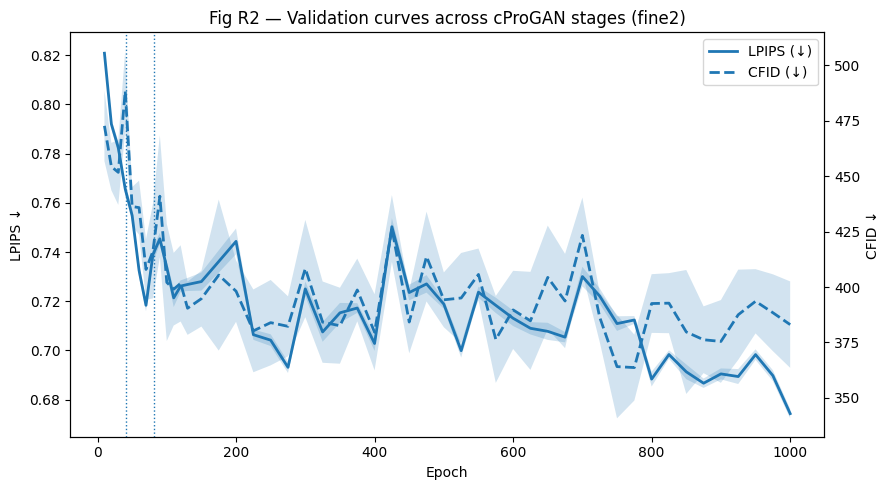

[fine3] Found 40 checkpoints in /content/drive/MyDrive/ImageNet_Images/GANs - fine3/cProGAN/cProGAN_checkpoint: [25, 50, 75, 100, 125, 150, 175, 200] ...
[fine3] epoch   25 | LPIPS 0.8156 ± 0.0011 | CFID 461.33 ± 21.83 | step 0, alpha 1.00
[fine3] epoch   50 | LPIPS 0.7769 ± 0.0010 | CFID 446.97 ± 15.54 | step 1, alpha 0.45


In [ ]:
# ===========================================
# Fig R2 — LPIPS↓ & Inception-based CFID↓ vs Epoch (FAST)
# - Strict checkpoint discovery in .../cProGAN/cProGAN_checkpoint (e###)
# - AMP for Generator + Inception (LPIPS stays fp32)
# - LPIPS upsample to 96×96 to avoid pooling crash
# - CFID uses per-class stats + class-bootstrap (cheap)
# - Vertical dashed lines = grow_schedule stage transitions
# ===========================================

import os, re, random, warnings
from typing import List, Dict, Tuple

import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as T

# Metrics / feature extractors
import lpips
from pytorch_fid.inception import InceptionV3
from scipy import linalg

warnings.filterwarnings("ignore")

# -----------------------------
# Reproducibility (seed, but allow fast kernels)
# -----------------------------
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True  # faster; turn off if strict determinism is required

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -----------------------------
# Data transform (model expects [-1,1])
# -----------------------------
img_transform = T.Compose([
    T.Resize(28),
    T.CenterCrop(28),
    T.ToTensor(),
    T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])

# -----------------------------
# Dataset (latents + real images + labels)
# -----------------------------
class LatentImageDataset(Dataset):
    def __init__(self, latents_npy, filenames_npy, labels_npy,
                 image_root, subject, transform):
        self.latents    = np.load(latents_npy)
        self.filenames  = np.load(filenames_npy, allow_pickle=True)
        self.labels_str = np.load(labels_npy)
        self.image_root = image_root
        self.transform  = transform
        self.sub        = np.load(subject, allow_pickle=True)

        classes = np.unique(self.labels_str)
        self.cls2idx = {c:i for i,c in enumerate(classes)}
        self.labels_int = np.array([self.cls2idx[c] for c in self.labels_str],
                                   dtype=np.int64)

    def __len__(self):
        return len(self.latents)

    def __getitem__(self, idx):
        z     = torch.from_numpy(self.latents[idx]).float()
        cls   = self.labels_str[idx]
        fname = self.filenames[idx]
        path  = os.path.join(self.image_root, cls, fname)
        img   = Image.open(path).convert("RGB")
        img   = self.transform(img)
        subj  = self.sub[idx]
        y_int = int(self.labels_int[idx])
        return z, img, fname, cls, y_int, subj

# -----------------------------
# LPIPS (VGG backbone) + safe upsample
# -----------------------------
LPIPS_SIZE = 96  # >=64 to survive VGG pooling
lpips_model = lpips.LPIPS(net="vgg").to(device).eval()

@torch.no_grad()
def lpips_distance(x_fake: torch.Tensor, x_real: torch.Tensor) -> torch.Tensor:
    """
    Inputs: [-1,1], [B,3,H,W] (H=W=28). We upsample to LPIPS_SIZE before LPIPS.
    Returns: [B] LPIPS on CPU.
    """
    xf = F.interpolate(x_fake, size=(LPIPS_SIZE, LPIPS_SIZE), mode="bilinear", align_corners=False)
    xr = F.interpolate(x_real, size=(LPIPS_SIZE, LPIPS_SIZE), mode="bilinear", align_corners=False)
    d = lpips_model(xf, xr)
    return d.view(-1).detach().cpu()

# -----------------------------
# Inception features for CFID (2048-D, pool3)
# -----------------------------
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
inception = InceptionV3([block_idx]).to(device).eval()

@torch.no_grad()
def get_inception_feats(x: torch.Tensor) -> torch.Tensor:
    """
    x: [-1,1], [B,3,H,W] -> [B,2048] features on CPU (float32)
    Uses AMP on CUDA for speed.
    """
    use_amp = (device.type == "cuda")
    with torch.autocast(device_type=device.type, enabled=use_amp):
        xx = F.interpolate(x, size=(299,299), mode="bilinear", align_corners=False)
        xx = (xx * 0.5 + 0.5).clamp(0,1)  # to [0,1]
        feats = inception(xx)[0].squeeze(-1).squeeze(-1)
    return feats.float().cpu()

# -----------------------------
# Frechet distance
# -----------------------------
def frechet_distance(mu1: torch.Tensor,
                     sigma1: torch.Tensor,
                     mu2: torch.Tensor,
                     sigma2: torch.Tensor,
                     eps: float = 1e-6) -> float:
    mu1 = mu1.double().cpu().numpy()
    mu2 = mu2.double().cpu().numpy()
    sigma1 = sigma1.double().cpu().numpy()
    sigma2 = sigma2.double().cpu().numpy()

    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    tr_covmean = np.trace(covmean)
    fd = diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2.0 * tr_covmean
    return float(fd)

# -----------------------------
# FAST CFID: per-class stats + class bootstrap
# -----------------------------
def per_class_stats(feats: torch.Tensor, labels: List[str], min_n: int = 10
                   ) -> Dict[str, Tuple[torch.Tensor, torch.Tensor, int]]:
    """
    Return {class: (mu[D], Sigma[D,D], n)} on CPU tensors.
    """
    labels_np = np.array(labels)
    stats = {}
    for cls in np.unique(labels_np):
        idx = np.where(labels_np == cls)[0]
        if len(idx) < min_n:
            continue
        f = feats[idx]                      # [n,D] CPU float32
        mu = f.mean(0)
        d = f.shape[1]
        I = torch.eye(d)                    # CPU
        Sigma = torch.cov(f.T).float() + 1e-6 * I
        stats[cls] = (mu, Sigma, len(idx))
    return stats

def cfid_from_stats(real_stats: Dict[str, Tuple[torch.Tensor, torch.Tensor, int]],
                    fake_stats: Dict[str, Tuple[torch.Tensor, torch.Tensor, int]]
                   ) -> Tuple[float, np.ndarray, np.ndarray]:
    """
    Compute CFID using precomputed per-class (mu,Sigma,n).
    Returns:
      cfid_point: weighted average over classes
      class_dists: array[K]
      class_weights: array[K] (counts)
    """
    dists, weights = [], []
    for cls in set(real_stats.keys()).intersection(fake_stats.keys()):
        mu_r, S_r, n = real_stats[cls]
        mu_f, S_f, _ = fake_stats[cls]
        d_cf = frechet_distance(mu_r, S_r, mu_f, S_f)
        dists.append(d_cf)
        weights.append(n)
    if not dists:
        return float("nan"), np.array([]), np.array([])
    dists = np.array(dists, float)
    weights = np.array(weights, int)
    wnorm = weights / weights.sum()
    cfid_point = float(np.average(dists, weights=wnorm))
    return cfid_point, dists, weights

def class_bootstrap_mean_std_cfid(class_dists: np.ndarray,
                                  class_weights: np.ndarray,
                                  B: int,
                                  rng: np.random.Generator) -> Tuple[float, float]:
    """
    Bootstrap CFID by resampling classes (with replacement), weighting by sampled weights.
    """
    K = len(class_dists)
    if K == 0:
        return float("nan"), float("nan")
    vals = np.empty(B, dtype=np.float64)
    for b in range(B):
        idx = rng.integers(0, K, size=K, endpoint=False)
        vals[b] = np.average(class_dists[idx], weights=class_weights[idx])
    return float(vals.mean()), float(vals.std(ddof=1))

# -----------------------------
# Stage transition epochs from grow_schedule
# -----------------------------
def find_stage_transitions(grow_fn, max_epoch: int):
    transitions = []
    prev_step = None
    for e in range(1, max_epoch+1):
        step, alpha = grow_fn(e-1)
        if prev_step is None:
            prev_step = step
        elif step != prev_step:
            transitions.append(e)
            prev_step = step
    return transitions

# -----------------------------
# Strict checkpoint discovery (non-recursive, e### only)
# -----------------------------
CKPT_RE = re.compile(r'cprogan[a-z]*checkpoint_e(\d{3,})\.pth$', re.IGNORECASE)

def discover_checkpoints_exact(dir_path: str) -> Dict[int, str]:
    """
    Scan ONLY dir_path for files like: cProGAN*checkpoint_e###.pth
    Returns {epoch:int -> path:str}, sorted by epoch.
    """
    found: Dict[int, str] = {}
    if not os.path.isdir(dir_path):
        return found
    for fname in os.listdir(dir_path):
        m = CKPT_RE.match(fname)
        if not m:
            continue
        ep = int(m.group(1))
        found[ep] = os.path.join(dir_path, fname)
    return dict(sorted(found.items(), key=lambda kv: kv[0]))

def bootstrap_mean_and_std_lpips(lpips_values: np.ndarray, B: int, rng: np.random.Generator):
    """Bootstrap the mean LPIPS over samples; returns (mean, std)."""
    N = lpips_values.shape[0]
    if N == 0:
        return float("nan"), float("nan")
    means = np.empty(B, dtype=np.float64)
    for b in range(B):
        idx = rng.integers(0, N, size=N, endpoint=False)
        means[b] = lpips_values[idx].mean()
    return float(means.mean()), float(means.std(ddof=1))

def lpips_mean_std(lpips_vals: np.ndarray, bootstrap: bool, B: int, rng: np.random.Generator):
    """Return (mean, std) for LPIPS; uses bootstrap when requested & sample size is decent."""
    if bootstrap and lpips_vals.size >= 50:
        return bootstrap_mean_and_std_lpips(lpips_vals, B, rng)
    return float(lpips_vals.mean()), float(lpips_vals.std(ddof=1))


# -----------------------------
# Main evaluation & plotting
# -----------------------------
granularities = ["fine2", "fine3"]  # adjust as needed
BATCH_SIZE = 256
NUM_WORKERS = 4
BOOTSTRAP_SAMPLES = 100  # 50–100 is usually plenty with class-bootstrap

for g in granularities:
    # --- dataset / loader (VAL set) ---
    base = f"/content/drive/MyDrive/ImageNet_Images/latent_dumps/granularity/Time/all_channels/{g}"
    test_ds = LatentImageDataset(
        latents_npy   = f"{base}/val_latents.npy",
        filenames_npy = f"{base}/val_filenames.npy",
        labels_npy    = f"{base}/val_stringLabels.npy",
        image_root    = f"/content/drive/MyDrive/ImageNet_Images/images_80class",
        subject       = f"{base}/val_subject.npy",
        transform     = img_transform,
    )
    test_loader = DataLoader(
        test_ds, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=NUM_WORKERS, pin_memory=True
    )

    # --- classes per granularity (adjust if different) ---
    if g in ("coarse", "fine2"):
        n_classes = 40
    else:
        n_classes = 8

    generator = cProGenerator(latent_dim=128, n_classes=n_classes).to(device)

    result_folder = f'/content/drive/MyDrive/ImageNet_Images/testResults/cProGAN Metric Curves/{g}'
    os.makedirs(result_folder, exist_ok=True)

    # -------- discover checkpoints (STRICT dir & pattern) --------
    ckpt_dir  = f"/content/drive/MyDrive/ImageNet_Images/GANs - {g}/cProGAN/cProGAN_checkpoint"
    ckpts = discover_checkpoints_exact(ckpt_dir)
    if not ckpts:
        print(f"[{g}] No checkpoints found under: {ckpt_dir}")
        continue
    epochs_available = list(ckpts.keys())
    print(f"[{g}] Found {len(epochs_available)} checkpoints in {ckpt_dir}: {epochs_available[:8]}{' ...' if len(epochs_available)>8 else ''}")

    # -------- stage lines from grow schedule --------
    grow = grow_schedule(max_res=28, ep=40)
    stage_lines = find_stage_transitions(grow, max_epoch=max(epochs_available))

    # -------- precompute REAL features & labels once --------
    all_real_feats = []
    all_labels = []
    with torch.no_grad():
        for _, real_imgs, _, wnids, _, _ in test_loader:
            real_imgs = real_imgs.to(device, non_blocking=True)
            rf = get_inception_feats(real_imgs)   # CPU [B,2048]
            all_real_feats.append(rf)
            all_labels.extend(list(wnids))
    all_real_feats = torch.cat(all_real_feats, dim=0)   # [N,2048] CPU
    real_stats = per_class_stats(all_real_feats, all_labels)  # dict per class
    del all_real_feats  # free RAM

    # --- storage for curves ---
    epochs = []
    lpips_mu, lpips_std = [], []
    cfid_mu,  cfid_std  = [], []

    rng = np.random.default_rng(SEED)
    USE_AMP = (device.type == "cuda")

    for ep, ckpt_path in ckpts.items():
        # Load generator
        ckpt = torch.load(ckpt_path, map_location=device)
        generator.load_state_dict(ckpt["generator_state"])
        generator.eval()

        step, alpha = grow(ep-1)

        # Accumulate per-sample metrics & FAKE features (real stats cached)
        all_lpips = []
        all_fake_feats = []

        with torch.no_grad():
            for latents, real_imgs, _, _, y_int, _ in test_loader:
                latents   = latents.to(device, non_blocking=True)
                y         = y_int.to(device, non_blocking=True)
                real_imgs = real_imgs.to(device, non_blocking=True)

                # faster forward with AMP
                with torch.autocast(device_type=device.type, enabled=USE_AMP):
                    fakes = generator(latents, y, step, alpha)

                # LPIPS in fp32 on upsampled images
                all_lpips.append(lpips_distance(fakes, real_imgs))

                # Inception feats of fakes (AMP inside)
                ff = get_inception_feats(fakes)   # CPU float32
                all_fake_feats.append(ff)

        lpips_vals = torch.cat(all_lpips, dim=0).numpy()  # [N]
        fake_feats = torch.cat(all_fake_feats, dim=0)     # [N,2048] CPU

        # ---- CFID via per-class stats (single sqrtm per class) ----
        fake_stats = per_class_stats(fake_feats, all_labels)
        cf_point, class_dists, class_weights = cfid_from_stats(real_stats, fake_stats)

        # ---- Bootstrap: LPIPS over samples; CFID over classes ----
        lp_mu, lp_sd = lpips_mean_std(lpips_vals, bootstrap=True, B=BOOTSTRAP_SAMPLES, rng=rng)
        cf_mu, cf_sd = class_bootstrap_mean_std_cfid(class_dists, class_weights,
                                             BOOTSTRAP_SAMPLES, rng)


        epochs.append(ep)
        lpips_mu.append(lp_mu)
        lpips_std.append(lp_sd)
        cfid_mu.append(cf_mu)
        cfid_std.append(cf_sd)

        print(f"[{g}] epoch {ep:4d} | LPIPS {lp_mu:.4f} ± {lp_sd:.4f} | CFID {cf_mu:.2f} ± {cf_sd:.2f} | step {step}, alpha {alpha:.2f}")

        torch.cuda.empty_cache()

    # ------ Plot Fig R2 for this granularity ------
    if len(epochs) == 0:
        print(f"[{g}] No checkpoints plotted.")
        continue

    order = np.argsort(epochs)
    epochs_np = np.array(epochs)[order]
    lp_mu_np  = np.array(lpips_mu)[order]
    lp_sd_np  = np.array(lpips_std)[order]
    cf_mu_np  = np.array(cfid_mu)[order]
    cf_sd_np  = np.array(cfid_std)[order]

    plt.figure(figsize=(9,5))
    ax1 = plt.gca()

    # LPIPS (solid)
    ax1.plot(epochs_np, lp_mu_np, label="LPIPS (↓)", linewidth=2)
    ax1.fill_between(epochs_np, lp_mu_np - lp_sd_np, lp_mu_np + lp_sd_np, alpha=0.2)
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("LPIPS ↓")

    # CFID (dashed) on twin axis
    ax2 = ax1.twinx()
    ax2.plot(epochs_np, cf_mu_np, linestyle="--", linewidth=2, label="CFID (↓)")
    ax2.fill_between(epochs_np, cf_mu_np - cf_sd_np, cf_mu_np + cf_sd_np, alpha=0.2)
    ax2.set_ylabel("CFID ↓")

    # Stage transitions (vertical dashed lines)
    grow_max = max(epochs_np)
    stage_lines = [e for e in stage_lines if epochs_np.min() <= e <= grow_max]
    for e in stage_lines:
        ax1.axvline(e, linestyle=":", linewidth=1)

    # Combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

    plt.title(f"Fig R2 — Validation curves across cProGAN stages ({g})")
    plt.tight_layout()

    out_path = os.path.join(result_folder, f"Fig_R2_{g}.png")
    plt.savefig(out_path, dpi=220)
    plt.show()

print("Done. Figures saved in each granularity folder under 'cProGAN Metric Curves/'.")
